In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
nPerClass = 1000
imgSize = 91
x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)
# the two widths
widths = [1.8, 2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

    # create the gaussian with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y - ro[1])**2)/(2*widths[i%2]**2))

    # add some noise
    G = G + np.random.randn(imgSize, imgSize)/5


    # add to the tensor
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i] = i%2

labels = labels[:, None]



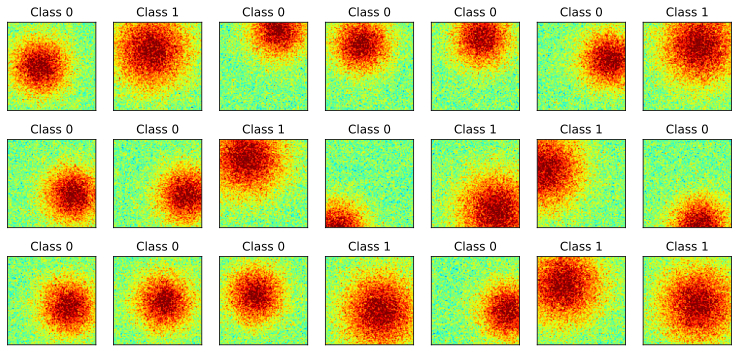

In [ ]:
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2*nPerClass)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G, vmin = -1, vmax = 1, cmap = 'jet')
    ax.set_title('Class %s' %int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
images = images.to(device)
labels = labels.to(device)
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size = 0.1)
print(train_data.device)
# convert into pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

# converting it into dataloader
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = len(test_data))

cuda:0


In [ ]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [ ]:
def makeTheNet(x):

    class gausnet(nn.Module):
        def __init__(self, x):
            super().__init__()

            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding = 1),
                nn.ReLU(),
                nn.AvgPool2d(2,2),
                nn.Conv2d(6, 4, 3, padding = 1),
                nn.ReLU(),
                nn.AvgPool2d(2, 2),
                nn.Flatten(),
                nn.Linear(22*22*4, 2*x),
                nn.Linear(2*x, x),
                nn.Linear(x, 1)
            )

        def forward(self, x):
            return self.enc(x)

    net = gausnet(x)
    net.to(device)

    lossfun = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [ ]:
net = makeTheNet(50)[0]
summary(net ,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                  [-1, 100]         193,700
            Linear-9                   [-1, 50]           5,050
           Linear-10                    [-1, 1]              51
Total params: 199,081
Trainable params: 199,081
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.01
Params size (MB): 0.76
Estimated T

In [ ]:
def function2TrainTheModel(x):

    numepochs = 10

    # create a new model
    net, lossfun, optimizer = makeTheNet(x)

    # initialize losses
    trainLoss = []
    testLoss = []
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            yHat = yHat.detach().cpu()
            loss = loss.detach().cpu()
            y = y.detach().cpu()

            batchLoss.append(loss)
            matches = torch.mean(((yHat > 0.5) == y).float()).item()
            accuracypct = 100*matches
            batchAcc.append(accuracypct)

        trainAcc.append(np.mean(batchAcc))
        trainLoss.append(np.mean(batchLoss))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            yHat = yHat.detach().cpu()
            loss = loss.detach().cpu()
            y = y.detach().cpu()
            matches = torch.mean(((yHat > 0.5) == y).float()).item()
            accuracypct = 100*matches
            testAcc.append(accuracypct)
            testLoss.append(loss)


    return trainAcc, testAcc, trainLoss, testLoss, net





In [ ]:
trainAcc, testAcc, trainLoss, testLoss, net = function2TrainTheModel(10)

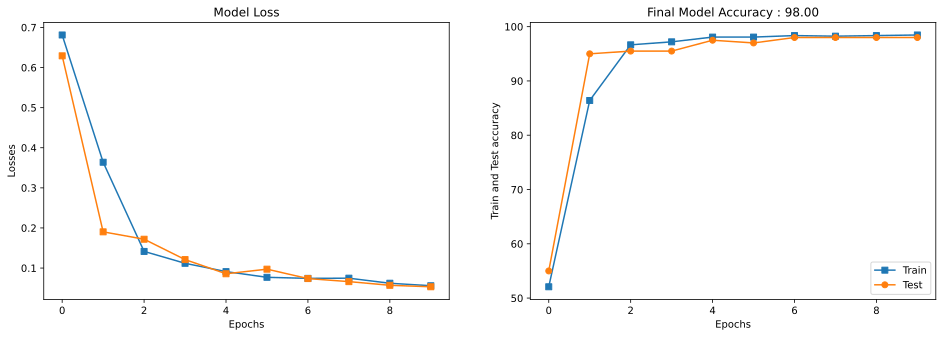

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(trainLoss, 's-')
ax[0].plot(testLoss, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, 's-', label = 'Train')
ax[1].plot(testAcc, 'o-', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Train and Test accuracy')
ax[1].set_title(f'Final Model Accuracy : {testAcc[-1]:.2f}')
ax[1].legend()

plt.show()

In [ ]:
fcUnits = np.linspace(5, 500, 20, dtype = int)

ftestAcc = []
ftrainAcc = []
ftestLoss = []
ftrainLoss = []

for fcUnit in fcUnits:
    trainAcc, testAcc, trainLoss, testLoss, net = function2TrainTheModel(fcUnit)
    ftestAcc.append(np.mean(testAcc[-5:]))
    ftrainAcc.append(np.mean(trainAcc[-5:]))
    ftestLoss.append(np.mean(testLoss[-5:]))
    ftrainLoss.append(np.mean(trainLoss[-5:]))


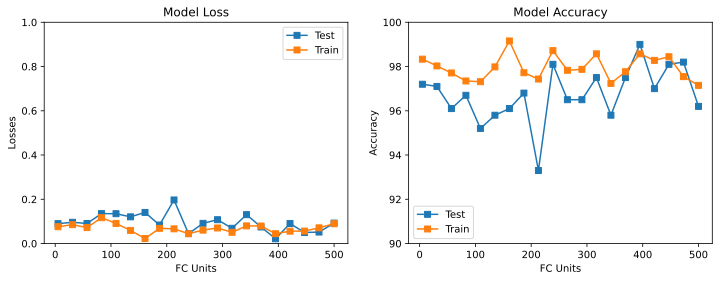

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (12,4))

axs[0].plot(fcUnits, ftestLoss,'s-', label = 'Test')
axs[0].plot(fcUnits, ftrainLoss,'s-', label = 'Train')
axs[0].set_xlabel('FC Units')
axs[0].set_ylabel('Losses')
axs[0].set_title('Model Loss')
axs[0].set_ylim([0,1])

axs[0].legend()

axs[1].plot(fcUnits, ftestAcc,'s-' ,label = 'Test')
axs[1].plot(fcUnits, ftrainAcc,'s-', label = 'Train')
axs[1].set_xlabel('FC Units')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model Accuracy')
axs[1].set_ylim([90,100])
axs[1].legend()

plt.show()